In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import MACA as maca

from scipy import io
from scipy.sparse import csr_matrix

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
##plot function
def plot_ann_umap(ad=None,ann=None):
    cluster_names = {}
    code, uniques = pd.factorize(ann)
    ad.obs['groups']=code.astype(str)
    for i in range(len(uniques)):
        cluster_names[str(i)]=str(i)+": "+uniques[i]

    ad.obs['Annotation'] = ad.obs['groups'].apply(lambda s: cluster_names[s])
    plt.figure(figsize=(8, 8))
    sc.pl.embedding(ad, basis='umap', color='Annotation', ax=plt.gca(), 
                    show=False)#, alpha=0.01#, size=10)

    df = pd.DataFrame(ad.obsm['X_umap'])
    df['cluster'] = ad.obs['groups'].values
    mean_pos = df.groupby('cluster').median()

    for c in mean_pos.index:    
        plt.gca().text(mean_pos.loc[c][0], mean_pos.loc[c][1], c.split(':')[0], 
                       fontsize=16, color='black')

    plt.title('Annotation')
    plt.show()

In [3]:
cell_markers={}

##Add PanglaoDB celltypes and markers
##Use PanglaoDB as marker database
##PanglaoDB available at https://panglaodb.se/index.html
#pg_df = pd.read_table("MACA/PanglaoDB_markers_27_Mar_2020.tsv")
##remove mouse specific genes
#pg_df = pg_df[pg_df['species']!='Mm']
#for i in list(set(pg_df["cell type"].values.tolist())):
#    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
#    ##only use cell type with at least 5 genes and less than 300 genes
#    if len(genes)>=5 and len(genes)<=300:
#        cell_markers[i]=genes


##human lung atlas markers
markers_xls = pd.ExcelFile('Downloads/Atlas_markers/Lung/41586_2020_2922_MOESM6_ESM.xlsx')

for cluster in markers_xls.sheet_names:
    if 'SS2' not in cluster and 'SS' not in cluster:
        markers = pd.read_excel(markers_xls, cluster,header=None,index_col=False)
        celltype = markers.iloc[0,0]
        markers = pd.read_excel(markers_xls, cluster,header=1,index_col=0)
        markers = markers[markers['avg_logFC'].values>=1]
        markers = markers[markers['pct_in_cluster'].values>=0.8]
        markers = markers[markers['pct_out_cluster'].values<0.5]
        markers = markers.index.tolist()
        if len(markers)>=5 and len(markers)<=300:
            cell_markers[celltype]=markers
        
###human kidney atlas markers
#markers_dir = "Downloads/Atlas_markers/Kidney/"
#files = os.listdir(markers_dir)

#for f in files:
#    markers = pd.read_csv(markers_dir+f,index_col=0, header=1)
#    logFold = np.log((markers['geneExpression'].values+1)/(markers['geneExpressionOutsideCluster'].values+1))
#    markers = markers[logFold>=1]
#    markers = markers[markers['geneFrequency'].values>=0.8]
#    markers = markers[markers['geneFrequencyOutsideCluster'].values<0.5]
#    celltypes = markers['Cell.type'].values.tolist()
#    celltypes = list(set(celltypes))
#    for c in celltypes:
#        sub_markers = markers[markers['Cell.type'].values==c]
#        m = sub_markers['Gene'].values.tolist()
#        if len(m)>=5 and len(m)<=300:
#            cell_markers[c]=m

In [5]:
data = "Downloads/20210217_NasalSwab_Broad_BCH_UMMC_to_CZI.h5ad"
adata5 = sc.read_h5ad(data)
adata5 = adata5[adata5.obs['SARSCoV2_PCR_Status']=="neg"]
adata5 = adata5[adata5.obs['Bloody_Swab']=='No']
adata5.obs['Donor']=adata5.obs['donor_id']
adata5.obs['CellType']=adata5.obs['Coarse_Cell_Annotations']
adata5.obs['Condition']='Healthy'
print(adata5.X.shape)

adata = adata5.copy()

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##run MACA
start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

adata5.obs['Annotation']=annotation

Trying to set attribute `.obs` of view, copying.


(12477, 32871)


Trying to set attribute `.obs` of view, copying.


(12477, 42)
(12477, 42)
--- 0 mins ---


In [6]:
data = "Downloads/Immunodeficiency_Nasal_swabs.h5ad"
adata6 = sc.read_h5ad(data)
adata6.obs['Condition']='COVID_1'
adata6.obs['Donor']=adata6.obs['Donor Id']
print(adata6.X.shape)

adata = adata6.copy()

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##run MACA
start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

adata6.obs['Annotation']=annotation

(4936, 33567)


Trying to set attribute `.obs` of view, copying.


(4936, 42)
(4936, 42)
--- 0 mins ---


In [7]:
genes = pd.read_table("Downloads/COVID_chua/covid_airway_genes.txt",header=None,index_col=False)
metadata = pd.read_csv("Downloads/COVID_chua/covid_airway_metadata.csv",header=0,index_col=0)
data = "Downloads/COVID_chua/covid_airway.mtx"
data = io.mmread(data)
data = csr_matrix(data)
data = data.T
adata7 = anndata.AnnData(X=data)
sc.pp.normalize_total(adata7, target_sum=1e4)
sc.pp.log1p(adata7)
adata7.var.index = genes[0].values
adata7=adata7[metadata['infection']!='healthy']
metadata=metadata[metadata['infection']!='healthy']
adata7.obs=metadata
adata7.obs['Condition']='COVID_2'
adata7.obs['Donor']=adata7.obs['patient']
adata7.obs['CellType']=adata7.obs['celltype']
print(adata7.X.shape)

adata = adata7.copy()

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##run MACA
start_time = time.time()

##step 1 expression to cell type score
scores, labels = maca.gene2cell(ad=ad,cell_markers=cell_markers)

##step 2 clustering
label_list = maca.parallel(scores=scores,labels=labels)

##step 3 ensemble
annotation = maca.ensemble_labels(label_list)
annotation = np.array(annotation)

print("--- %s mins ---" % int((time.time() - start_time)/60))

adata7.obs['Annotation']=annotation

(132618, 26924)
(132618, 41)
--- 4 mins ---


In [8]:
data = "Downloads/ucl-sanger_covid_airway.submit_to_czi.cellxgene.20200911.h5ad"
adata8 = sc.read_h5ad(data)
adata8.obs['Donor']=adata8.obs['SampleID']
adata8.obs['CellType']=adata8.obs['Annotation']
adata8.obs['Condition']='COVID_3'

adata = adata8.copy()

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##run MACA
start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

adata8.obs['Annotation']=annotation

Trying to set attribute `.obs` of view, copying.


(10550, 42)
(10550, 42)
--- 0 mins ---


In [9]:
data = "Downloads/20210217_NasalSwab_Broad_BCH_UMMC_to_CZI.h5ad"
adata9 = sc.read_h5ad(data)
adata9 = adata9[adata9.obs['Bloody_Swab']=='No']
adata9.obs['Donor']=adata9.obs['donor_id']
adata9.obs['CellType']=adata9.obs['Coarse_Cell_Annotations']
adata9 = adata9[adata9.obs['SARSCoV2_PCR_Status']=='pos']
adata9.obs['Condition']="COVID_4"

adata = adata9.copy()

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##run MACA
start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

adata9.obs['Annotation']=annotation

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(15405, 42)
(15405, 42)
--- 0 mins ---


In [10]:
var_names = adata5.var_names.intersection(adata6.var_names)
var_names = var_names.intersection(adata7.var_names)
var_names = var_names.intersection(adata8.var_names)
var_names = var_names.intersection(adata9.var_names)

data5 = adata5[:,var_names]
adata6 = adata6[:,var_names]
adata7 = adata7[:,var_names]
adata8 = adata8[:,var_names]
adata9 = adata9[:,var_names]

adata = adata5.concatenate(adata6,adata7,adata8,adata9)

In [11]:
patients = list(set(adata.obs['Donor']))
celltypes = list(set(adata.obs['Annotation']))
ad_coda_pd = np.zeros((len(patients),len(celltypes)+1))
for p in range(len(patients)):
    subad = adata[adata.obs['Donor']==patients[p]]
    for i in range(len(celltypes)):
        subcell = subad[subad.obs['Annotation']==celltypes[i]]
        ad_coda_pd[p,i]=subcell.X.shape[0]
        
ad_coda_pd = pd.DataFrame(ad_coda_pd)
celltypes.append('Individuals')
ad_coda_pd.columns = celltypes
ad_coda_pd.iloc[:,-1]=patients
ad_coda = dat.from_pandas(ad_coda_pd, covariate_columns=["Individuals"])

In [12]:
a=list(set(adata5.obs['Donor'].tolist()))
b=list(set(adata6.obs['Donor'].tolist()))
c=list(set(adata7.obs['Donor'].tolist()))
d=list(set(adata8.obs['Donor'].tolist()))

conditions = []
for i in ad_coda.obs['Individuals']:
    if i in a:
        conditions.append("Healthy")
    elif i in b:
        conditions.append("COVID_1")
    elif i in c:
        conditions.append("COVID_2")
    elif i in d:
        conditions.append("COVID_3")
    else:
        conditions.append("COVID_4")

ad_coda.obs['Condition']=conditions
ad_coda.obs['Individuals']=["Participant"+str(i+1) for i in range(ad_coda.X.shape[0])]
ad_coda.obs['Condition'][ad_coda.obs['Condition']!="Healthy"]="COVID"

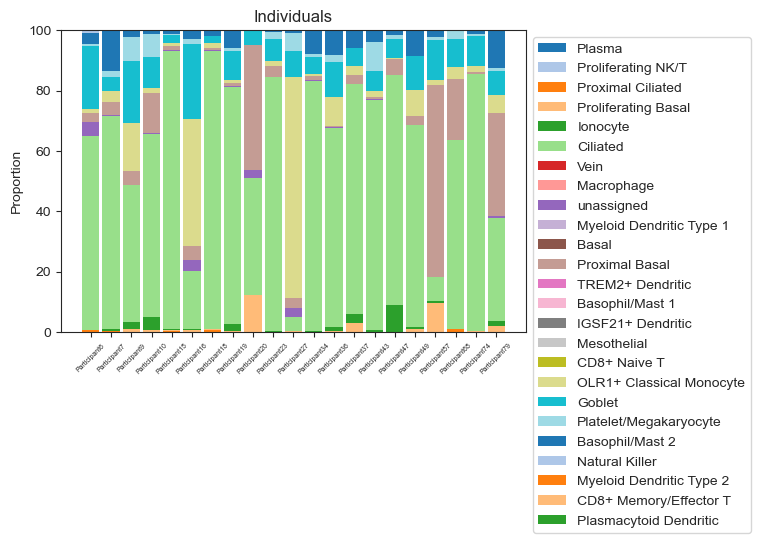

In [13]:
ad_coda_sub = ad_coda[ad_coda.obs['Condition']=="Healthy"]
viz.stacked_barplot(ad_coda_sub, feature_name="Individuals")
plt.xticks(fontsize=5)
plt.savefig('COVID_comp_healthy.pdf',dpi=450)

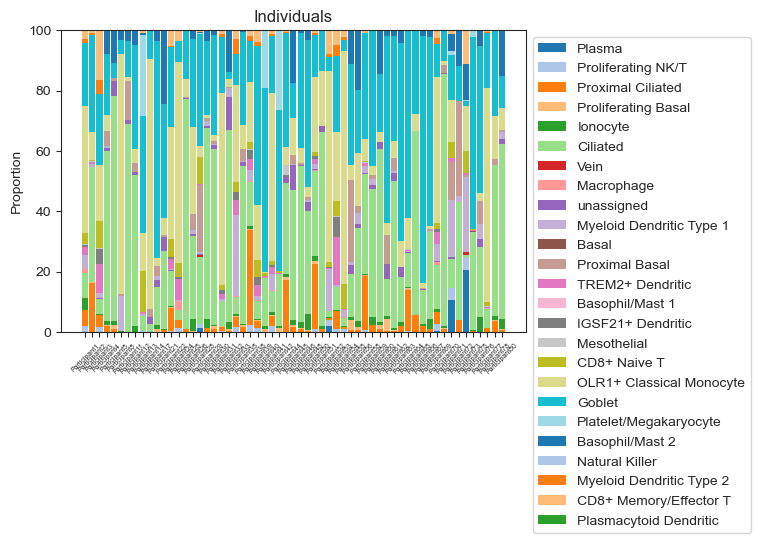

In [14]:
ad_coda_sub = ad_coda[ad_coda.obs['Condition']!="Healthy"]
viz.stacked_barplot(ad_coda_sub, feature_name="Individuals")
plt.xticks(fontsize=5)
plt.savefig('COVID_comp_COVID.pdf',dpi=450)

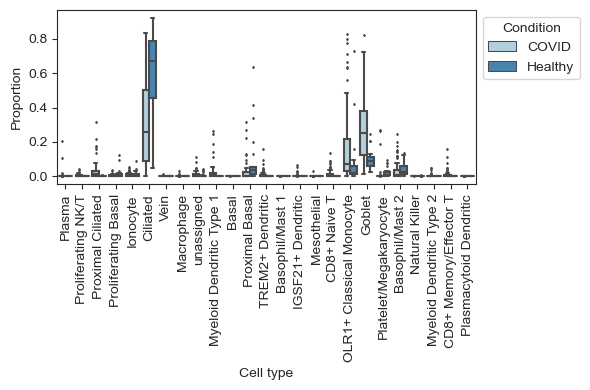

In [15]:
viz.boxplots(ad_coda, feature_name="Condition",plot_facets=False,add_dots=False)
plt.savefig('COVID_ct_prop_comp.pdf',dpi=450)

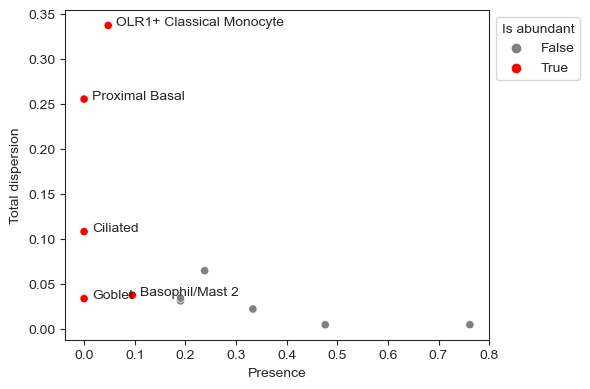

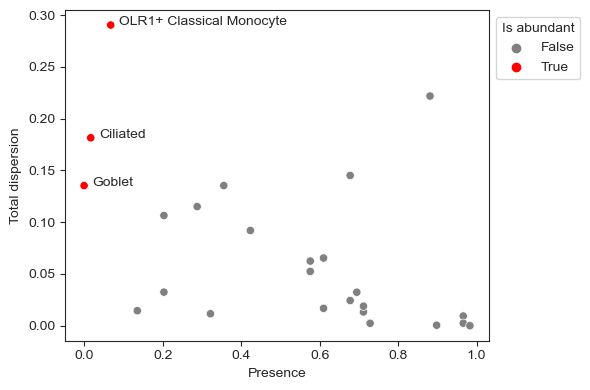

In [16]:
viz.rel_abundance_dispersion_plot(
    data=ad_coda[ad_coda.obs['Condition']=="Healthy"],
    abundant_threshold=0.9
)
plt.show()

viz.rel_abundance_dispersion_plot(
    data=ad_coda[ad_coda.obs['Condition']=="COVID"],
    abundant_threshold=0.9
)
plt.show()

In [21]:
model_salm = mod.CompositionalAnalysis(ad_coda, formula="Condition", reference_cell_type="Proximal Basal")
sim_results = model_salm.sample_hmc()
sim_results.summary()

Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (132.043 sec)
Acceptance rate: 63.6%
Compositional Analysis summary:

Data: 80 samples, 34 cell types
Reference index: 7
Formula: Condition

Intercepts:
                                              Final Parameter  Expected Sample
Cell Type                                                                     
Pancreatic stellate cells                              -1.503        25.859185
Basal cells                                            -1.471        26.700061
Fibroblasts                                            -1.504        25.833339
B cells naive                                          -1.464        26.887617
unassigned                                             -1.417        28.181503
Plasmacytoid Dendritic                                 -1.375        29.390334
TREM2+ Dendritic                                       -1.142        37.101814
Proximal Basal                                     